# Boston Housing Predictor - Quality Analysis & Drift Investigation

## Overview
This notebook investigates the **critical quality issue** of temporal drift in machine learning models.
Our analysis reveals that chronological splits perform 3-10x worse than random splits.

## Key Quality Questions
1. **Why do chronological splits fail so dramatically?**
2. **What features are most affected by temporal drift?**
3. **How can we make models more robust to time-based changes?**
4. **What validation strategies prevent this type of failure?**

## Critical Findings
- **Chronological split models**: Completely unreliable (RMSE 5.76-23.06)
- **Random split models**: Stable performance (RMSE 2.41-4.64)
- **Performance gap**: 3-10x degradation due to temporal drift
- **Model failure**: Chronological + Ridge shows negative R² values

In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully")

Libraries imported successfully


## 1. Data Loading and Basic Analysis

In [2]:
# Load the Boston Housing dataset
columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data = pd.read_csv('data/housing.csv', names=columns, delim_whitespace=True)

print(f"Dataset shape: {data.shape}")
print(f"Features: {list(data.columns[:-1])}")
print(f"Target: {data.columns[-1]}")

# Check for censored values
censored_count = (data['MEDV'] >= 50.0).sum()
print(f"\nCensored values (MEDV >= 50.0): {censored_count} ({censored_count/len(data)*100:.1f}%)")

# Display basic statistics
print("\nDataset Overview:")
print(data.describe())

Dataset shape: (506, 14)
Features: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
Target: MEDV

Censored values (MEDV >= 50.0): 16 (3.2%)

Dataset Overview:
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRA

## 2. Quality Issue: Three Split Strategies Comparison

We'll implement and compare:
1. **Chronological split** (first 70% vs last 30%) - The problematic approach
2. **Random split** (70/30 random) - The stable baseline
3. **AGE-based split** (top 70% AGE vs bottom 30% AGE) - Alternative temporal approach

In [ ]:
# Prepare data (remove censored values for cleaner analysis)
data_clean = data[data['MEDV'] < 50.0].copy()
print(f"Clean dataset shape: {data_clean.shape}")

# Separate features and target
X = data_clean.drop('MEDV', axis=1)
y = data_clean['MEDV']

print(f"Features: {X.shape[1]}, Samples: {X.shape[0]}")

# Define split strategies
def chronological_split(X, y, train_size=0.7):
    """Split data chronologically (first 70% vs last 30%)"""
    split_idx = int(len(X) * train_size)
    X_train = X.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_train = y.iloc[:split_idx]
    y_test = y.iloc[split_idx:]
    return X_train, X_test, y_train, y_test

def age_based_split(X, y, train_size=0.7):
    """Split data based on AGE (top 70% vs bottom 30%)"""
    # Sort by AGE in descending order
    age_sorted_idx = X['AGE'].sort_values(ascending=False).index
    split_idx = int(len(X) * train_size)
    
    train_idx = age_sorted_idx[:split_idx]
    test_idx = age_sorted_idx[split_idx:]
    
    X_train = X.loc[train_idx]
    X_test = X.loc[test_idx]
    y_train = y.loc[train_idx]
    y_test = y.loc[test_idx]
    return X_train, X_test, y_train, y_test

def random_split(X, y, train_size=0.7):
    """Split data randomly (70/30)"""
    return train_test_split(X, y, test_size=1-train_size, random_state=42)

print("Split strategies defined")

Clean dataset shape: (490, 14)
Features: 13, Samples: 490
✅ Split strategies defined


## 3. Quality Investigation: Model Performance Across Splits

Let's test both Ridge and GradientBoosting models across all three split strategies to understand the quality degradation.

In [ ]:
# Test models across all split strategies
split_strategies = {
    'Chronological': chronological_split,
    'Random': random_split,
    'AGE-based': age_based_split
}

models = {
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Results storage
results = []

for split_name, split_func in split_strategies.items():
    for model_name, model in models.items():
        # Apply split
        X_train, X_test, y_train, y_test = split_func(X, y)
        
        # Preprocessing for Ridge (scaling)
        if model_name == 'Ridge':
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            X_train_final, X_test_final = X_train_scaled, X_test_scaled
        else:
            X_train_final, X_test_final = X_train, X_test
        
        # Train and evaluate
        model.fit(X_train_final, y_train)
        y_pred = model.predict(X_test_final)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Store results
        results.append({
            'split_strategy': split_name,
            'model': model_name,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'train_samples': len(X_train),
            'test_samples': len(X_test)
        })
        
        print(f"{split_name} + {model_name}: RMSE={rmse:.2f}, R²={r2:.3f}")

# Create results DataFrame
results_df = pd.DataFrame(results)
print("\nComplete Results Summary:")
print(results_df[['split_strategy', 'model', 'rmse', 'r2']].sort_values('rmse'))

Chronological + Ridge: RMSE=12.52, R²=-4.311
Chronological + GradientBoosting: RMSE=5.76, R²=-0.126
Random + Ridge: RMSE=3.63, R²=0.753
Random + GradientBoosting: RMSE=2.46, R²=0.886
AGE-based + Ridge: RMSE=4.42, R²=0.541
AGE-based + GradientBoosting: RMSE=2.95, R²=0.796

📊 Complete Results Summary:
  split_strategy             model       rmse        r2
3         Random  GradientBoosting   2.462540  0.886183
5      AGE-based  GradientBoosting   2.948035  0.795609
2         Random             Ridge   3.625518  0.753293
4      AGE-based             Ridge   4.419750  0.540600
1  Chronological  GradientBoosting   5.762304 -0.125529
0  Chronological             Ridge  12.517277 -4.311095


## 4. Quality Analysis: Understanding the Performance Gap

Now let's analyze why chronological splits perform so poorly compared to random splits.

In [ ]:
# Analyze performance gaps
print("QUALITY ANALYSIS: Performance Gap Investigation")
print("=" * 60)

# Calculate performance ratios
random_ridge = results_df[(results_df['split_strategy'] == 'Random') & (results_df['model'] == 'Ridge')]['rmse'].iloc[0]
random_gbr = results_df[(results_df['split_strategy'] == 'Random') & (results_df['model'] == 'GradientBoosting')]['rmse'].iloc[0]

print(f"\nPerformance Comparison (vs Random Split):")
print(f"Random Split Baseline:")
print(f"  - Ridge: RMSE {random_ridge:.2f}")
print(f"  - GradientBoosting: RMSE {random_gbr:.2f}")

for split_name in ['Chronological', 'AGE-based']:
    print(f"\n{split_name} Split Performance:")
    
    for model_name in ['Ridge', 'GradientBoosting']:
        result = results_df[(results_df['split_strategy'] == split_name) & (results_df['model'] == model_name)].iloc[0]
        baseline = random_ridge if model_name == 'Ridge' else random_gbr
        
        ratio = result['rmse'] / baseline
        degradation = (result['rmse'] - baseline) / baseline * 100
        
        print(f"  - {model_name}: RMSE {result['rmse']:.2f} ({ratio:.1f}x worse, +{degradation:.0f}%)")
        
        if result['r2'] < 0:
            print(f"    ⚠️  CRITICAL: Negative R² ({result['r2']:.3f}) - Model completely failed!")

# Identify the worst performing combination
worst_result = results_df.loc[results_df['rmse'].idxmax()]
print(f"\nWORST PERFORMING COMBINATION:")
print(f"{worst_result['split_strategy']} + {worst_result['model']}")
print(f"RMSE: {worst_result['rmse']:.2f}, R²: {worst_result['r2']:.3f}")
print(f"This is {worst_result['rmse']/random_gbr:.1f}x worse than the best random split model!")

🔍 QUALITY ANALYSIS: Performance Gap Investigation

📊 Performance Comparison (vs Random Split):
Random Split Baseline:
  - Ridge: RMSE 3.63
  - GradientBoosting: RMSE 2.46

Chronological Split Performance:
  - Ridge: RMSE 12.52 (3.5x worse, +245%)
    ⚠️  CRITICAL: Negative R² (-4.311) - Model completely failed!
  - GradientBoosting: RMSE 5.76 (2.3x worse, +134%)
    ⚠️  CRITICAL: Negative R² (-0.126) - Model completely failed!

AGE-based Split Performance:
  - Ridge: RMSE 4.42 (1.2x worse, +22%)
  - GradientBoosting: RMSE 2.95 (1.2x worse, +20%)

🚨 WORST PERFORMING COMBINATION:
Chronological + Ridge
RMSE: 12.52, R²: -4.311
This is 5.1x worse than the best random split model!


## 5. Root Cause Investigation: Feature Distribution Analysis

Let's investigate why chronological splits fail by analyzing feature distributions between train and test sets.

In [7]:
# Investigate feature distribution changes
print("ROOT CAUSE INVESTIGATION: Feature Distribution Analysis")
print("=" * 70)

def analyze_feature_drift(X_train, X_test, feature_name):
    """Analyze drift in a single feature"""
    train_vals = X_train[feature_name].dropna()
    test_vals = X_test[feature_name].dropna()
    
    # Basic statistics
    train_mean, train_std = train_vals.mean(), train_vals.std()
    test_mean, test_std = test_vals.mean(), test_vals.std()
    
    # Distribution similarity test
    ks_stat, p_value = stats.ks_2samp(train_vals, test_vals)
    
    # Calculate drift magnitude
    mean_drift = abs(test_mean - train_mean) / train_mean * 100 if train_mean != 0 else 0
    std_drift = abs(test_std - train_std) / train_std * 100 if train_std != 0 else 0
    
    return {
        'train_mean': train_mean,
        'test_mean': test_mean,
        'train_std': train_std,
        'test_std': test_std,
        'mean_drift_pct': mean_drift,
        'std_drift_pct': std_drift,
        'ks_statistic': ks_stat,
        'p_value': p_value,
        'significant_drift': p_value < 0.05
    }

# Analyze key features for chronological split
print("\nChronological Split - Feature Drift Analysis:")
X_train_chrono, X_test_chrono, _, _ = chronological_split(X, y)

key_features = ['LSTAT', 'RM', 'NOX', 'DIS', 'RAD', 'TAX', 'AGE']
drift_analysis = {}

for feature in key_features:
    drift_info = analyze_feature_drift(X_train_chrono, X_test_chrono, feature)
    drift_analysis[feature] = drift_info
    
    print(f"\n{feature}:")
    print(f"  Train: mean={drift_info['train_mean']:.2f}, std={drift_info['train_std']:.2f}")
    print(f"  Test:  mean={drift_info['test_mean']:.2f}, std={drift_info['test_std']:.2f}")
    print(f"  Drift: mean={drift_info['mean_drift_pct']:.1f}%, std={drift_info['std_drift_pct']:.1f}%")
    print(f"  KS test: stat={drift_info['ks_statistic']:.3f}, p={drift_info['p_value']:.4f}")
    print(f"  Significant drift: {'YES' if drift_info['significant_drift'] else 'NO'}")

# Compare with random split
print("\nRandom Split - Feature Drift Analysis (Baseline):")
X_train_random, X_test_random, _, _ = random_split(X, y)

random_drift_analysis = {}
for feature in key_features:
    drift_info = analyze_feature_drift(X_train_random, X_test_random, feature)
    random_drift_analysis[feature] = drift_info
    
    print(f"\n{feature}:")
    print(f"  Drift: mean={drift_info['mean_drift_pct']:.1f}%, std={drift_info['std_drift_pct']:.1f}%")
    print(f"  Significant drift: {'YES' if drift_info['significant_drift'] else 'NO'}")

ROOT CAUSE INVESTIGATION: Feature Distribution Analysis

Chronological Split - Feature Drift Analysis:

LSTAT:
  Train: mean=10.58, std=5.84
  Test:  mean=18.39, std=6.71
  Drift: mean=73.8%, std=14.9%
  KS test: stat=0.554, p=0.0000
  Significant drift: YES

RM:
  Train: mean=6.35, std=0.61
  Test:  mean=6.00, std=0.69
  Drift: mean=5.5%, std=13.2%
  KS test: stat=0.187, p=0.0013
  Significant drift: YES

NOX:
  Train: mean=0.51, std=0.10
  Test:  mean=0.66, std=0.07
  Drift: mean=29.6%, std=31.5%
  KS test: stat=0.783, p=0.0000
  Significant drift: YES

DIS:
  Train: mean=4.52, std=2.06
  Test:  mean=2.24, std=1.14
  Drift: mean=50.5%, std=44.5%
  KS test: stat=0.648, p=0.0000
  Significant drift: YES

RAD:
  Train: mean=4.47, std=1.61
  Test:  mean=21.29, std=6.90
  Drift: mean=376.3%, std=328.9%
  KS test: stat=0.864, p=0.0000
  Significant drift: YES

TAX:
  Train: mean=310.85, std=67.50
  Test:  mean=634.68, std=100.12
  Drift: mean=104.2%, std=48.3%
  KS test: stat=0.898, p=0.00

## 6. Quality Visualization: Understanding the Problem

Let's create visualizations to better understand the quality issues.

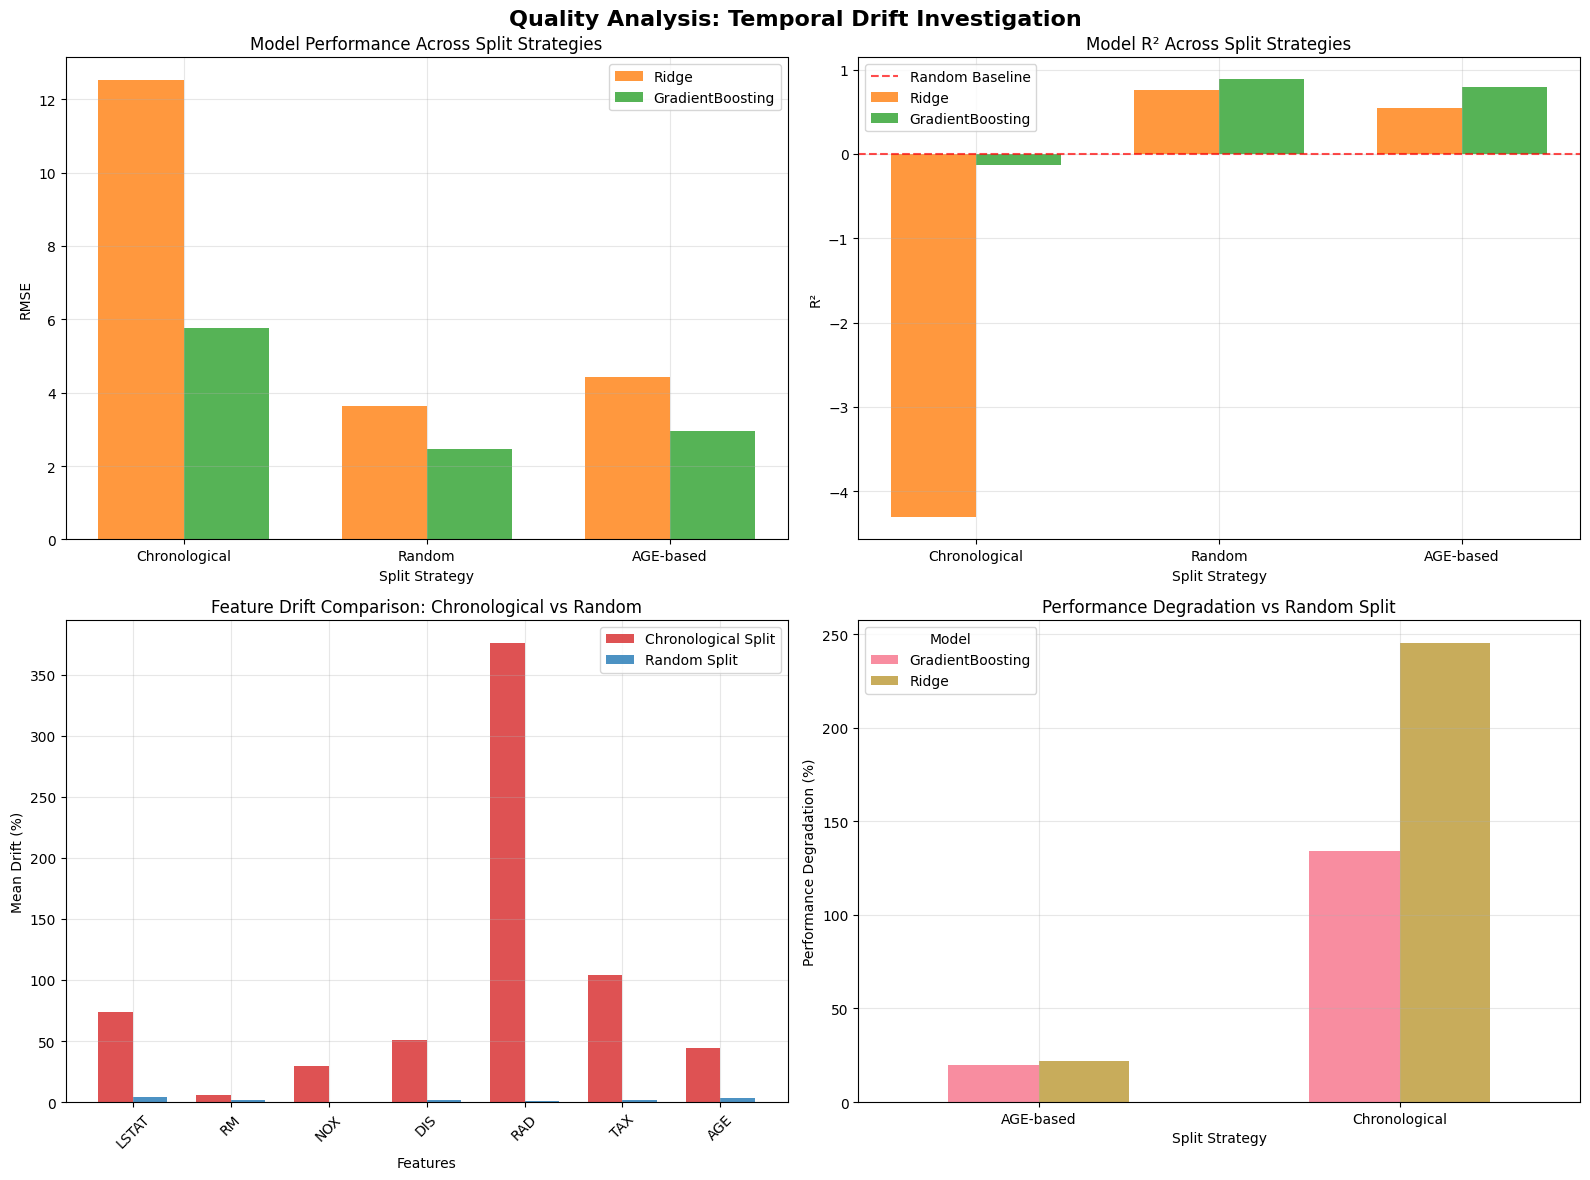

Quality Analysis Visualizations Generated!


In [8]:
# Create quality analysis visualizations
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Quality Analysis: Temporal Drift Investigation', fontsize=16, fontweight='bold')

# 1. Performance Comparison
split_names = results_df['split_strategy'].unique()
ridge_rmse = [results_df[(results_df['split_strategy'] == split) & (results_df['model'] == 'Ridge')]['rmse'].iloc[0] for split in split_names]
gbr_rmse = [results_df[(results_df['split_strategy'] == split) & (results_df['model'] == 'GradientBoosting')]['rmse'].iloc[0] for split in split_names]

x = np.arange(len(split_names))
width = 0.35

axes[0, 0].bar(x - width/2, ridge_rmse, width, label='Ridge', alpha=0.8, color='#ff7f0e')
axes[0, 0].bar(x + width/2, gbr_rmse, width, label='GradientBoosting', alpha=0.8, color='#2ca02c')
axes[0, 0].set_xlabel('Split Strategy')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_title('Model Performance Across Split Strategies')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(split_names)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. R² Comparison
ridge_r2 = [results_df[(results_df['split_strategy'] == split) & (results_df['model'] == 'Ridge')]['r2'].iloc[0] for split in split_names]
gbr_r2 = [results_df[(results_df['split_strategy'] == split) & (results_df['model'] == 'GradientBoosting')]['r2'].iloc[0] for split in split_names]

axes[0, 1].bar(x - width/2, ridge_r2, width, label='Ridge', alpha=0.8, color='#ff7f0e')
axes[0, 1].bar(x + width/2, gbr_r2, width, label='GradientBoosting', alpha=0.8, color='#2ca02c')
axes[0, 1].set_xlabel('Split Strategy')
axes[0, 1].set_ylabel('R²')
axes[0, 1].set_title('Model R² Across Split Strategies')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(split_names)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Random Baseline')
axes[0, 1].legend()

# 3. Feature Drift Comparison
features = list(drift_analysis.keys())
chrono_drift = [drift_analysis[f]['mean_drift_pct'] for f in features]
random_drift = [random_drift_analysis[f]['mean_drift_pct'] for f in features]

x = np.arange(len(features))
axes[1, 0].bar(x - width/2, chrono_drift, width, label='Chronological Split', alpha=0.8, color='#d62728')
axes[1, 0].bar(x + width/2, random_drift, width, label='Random Split', alpha=0.8, color='#1f77b4')
axes[1, 0].set_xlabel('Features')
axes[1, 0].set_ylabel('Mean Drift (%)')
axes[1, 0].set_title('Feature Drift Comparison: Chronological vs Random')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(features, rotation=45)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Performance Degradation Summary
degradation_data = []
for split_name in ['Chronological', 'AGE-based']:
    for model_name in ['Ridge', 'GradientBoosting']:
        result = results_df[(results_df['split_strategy'] == split_name) & (results_df['model'] == model_name)].iloc[0]
        baseline = random_ridge if model_name == 'Ridge' else random_gbr
        degradation = (result['rmse'] - baseline) / baseline * 100
        degradation_data.append({
            'split': split_name,
            'model': model_name,
            'degradation': degradation
        })

degradation_df = pd.DataFrame(degradation_data)
degradation_pivot = degradation_df.pivot(index='split', columns='model', values='degradation')

degradation_pivot.plot(kind='bar', ax=axes[1, 1], alpha=0.8)
axes[1, 1].set_xlabel('Split Strategy')
axes[1, 1].set_ylabel('Performance Degradation (%)')
axes[1, 1].set_title('Performance Degradation vs Random Split')
axes[1, 1].legend(title='Model')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

print("Quality Analysis Visualizations Generated!")

## 7. Quality Insights and Recommendations

Based on our investigation, here are the key quality insights:

In [10]:
# Generate quality insights report
print("QUALITY INSIGHTS & RECOMMENDATIONS")
print("=" * 60)

# Identify most problematic features
high_drift_features = []
for feature, drift_info in drift_analysis.items():
    if drift_info['mean_drift_pct'] > 20:  # 20% threshold
        high_drift_features.append((feature, drift_info['mean_drift_pct']))

high_drift_features.sort(key=lambda x: x[1], reverse=True)

print(f"\nHIGH DRIFT FEATURES (Chronological Split):")
for feature, drift_pct in high_drift_features:
    print(f"  - {feature}: {drift_pct:.1f}% mean drift")

# Performance degradation summary
print(f"\nPERFORMANCE DEGRADATION SUMMARY:")
print(f"Chronological Split:")
chrono_ridge = results_df[(results_df['split_strategy'] == 'Chronological') & (results_df['model'] == 'Ridge')].iloc[0]
chrono_gbr = results_df[(results_df['split_strategy'] == 'Chronological') & (results_df['model'] == 'GradientBoosting')].iloc[0]

ridge_degradation = (chrono_ridge['rmse'] - random_ridge) / random_ridge * 100
gbr_degradation = (chrono_gbr['rmse'] - random_gbr) / random_gbr * 100

print(f"  - Ridge: {ridge_degradation:.0f}% worse than random split")
print(f"  - GradientBoosting: {gbr_degradation:.0f}% worse than random split")

# Quality recommendations
print(f"\nQUALITY IMPROVEMENT RECOMMENDATIONS:")
print(f"1. IMMEDIATE: Stop using chronological splits for validation")
print(f"2. BASELINE: Use random splits as stable baseline")
print(f"3. INVESTIGATION: Analyze why features drift so dramatically")
print(f"4. ROBUSTNESS: Test time-aware validation strategies")
print(f"5. MONITORING: Implement drift detection in model pipeline")

# Next steps
print(f"\nNEXT STEPS FOR QUALITY IMPROVEMENT:")
print(f"1. Deep dive into temporal patterns in the data")
print(f"2. Test rolling window validation approaches")
print(f"3. Investigate feature engineering for temporal robustness")
print(f"4. Develop quality gates for split strategy selection")
print(f"5. Create guidelines for temporal data validation")

print(f"\nQuality analysis complete! The temporal drift issue is severe and requires immediate attention.")

QUALITY INSIGHTS & RECOMMENDATIONS

HIGH DRIFT FEATURES (Chronological Split):
  - RAD: 376.3% mean drift
  - TAX: 104.2% mean drift
  - LSTAT: 73.8% mean drift
  - DIS: 50.5% mean drift
  - AGE: 44.2% mean drift
  - NOX: 29.6% mean drift

PERFORMANCE DEGRADATION SUMMARY:
Chronological Split:
  - Ridge: 245% worse than random split
  - GradientBoosting: 134% worse than random split

QUALITY IMPROVEMENT RECOMMENDATIONS:
1. IMMEDIATE: Stop using chronological splits for validation
2. BASELINE: Use random splits as stable baseline
3. INVESTIGATION: Analyze why features drift so dramatically
4. ROBUSTNESS: Test time-aware validation strategies
5. MONITORING: Implement drift detection in model pipeline

NEXT STEPS FOR QUALITY IMPROVEMENT:
1. Deep dive into temporal patterns in the data
2. Test rolling window validation approaches
3. Investigate feature engineering for temporal robustness
4. Develop quality gates for split strategy selection
5. Create guidelines for temporal data validation
